<a href="https://colab.research.google.com/github/polrgn/biomedical_clustering_topic_modeling/blob/main/2b_LSTM_autoencoder_rep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries and data

In [ ]:
import numpy as np 
import pandas as pd
import os

import pickle
import matplotlib.pyplot as plt

from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input,Dense, Dropout, LSTM, GRU, Reshape, TimeDistributed, RepeatVector, Embedding, Bidirectional, Masking, BatchNormalization

Mount Google drive

In [ ]:
# Mounting Google drive where we save our data and embeddings
#from google.colab import drive
#drive.mount('/content/drive/')

Load our clean dataset

In [ ]:
abstract_df = pd.read_csv('Data/abstract_df_clean_stopwords_lang_abstrlen.csv',index_col=0)[0:10000]
np.shape(abstract_df)

(10000, 3)

# Pre-processing dataset for the autoencoder

Fit the tokenizer on our dataset and save it.

In [ ]:
# Fit the tokenizer and build the word index
t= Tokenizer(num_words=None)
t.fit_on_texts(abstract_df.abstract)
pickle.dump(t, open("Outputs/autoencoder_vectorizer.pickle", "wb"))
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49554 unique tokens.


Save the vocabulary to build the embedding layer after. 

In [ ]:
word_index_df = pd.DataFrame(word_index.items())
word_index_df.columns=['word','index']
word_index_df['index'] = word_index_df['index']-1
word_index_df.head()
word_index_df.to_csv('Outputs/word_index.csv')

Read the pre-trained embeddings.

In [ ]:
# Extract the words vectors from BioWordVec embeddings txt file
embeddings_index = {}
f = open('Data/BioWordVec_PubMed_MIMICIII_d200.txt')
for line in f:
   values = line.split()
   word = values[0]
   coefs = np.asarray(values[1:], dtype='float32')
   embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Build our embedding matrix by matching the tokens (words) in our dataset to
the pre-trained embeddings.

Code inspired from
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

words_in_data = []
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
   embedding_vector = embeddings_index.get(word)
   if embedding_vector is not None:
       # words not found in embedding index will be all-zeros.
       embedding_matrix[i] = embedding_vector
       words_in_data.append(word)

Save our embedding matrix
np.savetxt('Outputs/embedding_matrix.csv', embedding_matrix, delimiter=',')

In [ ]:
# Load our saved embedding matrix
embedding_matrix = np.loadtxt('Outputs/embedding_matrix.csv',delimiter=',')

Build the embedding layer.

In [ ]:
maxlen = max(abstract_df.word_count)
EMBEDDING_DIM = np.shape(embedding_matrix)[1]
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length= maxlen,
                            trainable=False)

Tokenize, pad and embed the abstracts.

In [ ]:
tokenized= t.texts_to_sequences(abstract_df.abstract)
padded_abstract = pad_sequences(tokenized, maxlen=maxlen)
embedded_abstract= embedding_layer(padded_abstract)
np.shape(embedded_abstract)
np.save("Outputs/embedded_abstract", embedded_abstract)

In [ ]:
embedded_abstract = np.load('Outputs/embedded_abstract.npy')
np.save("Outputs/embedded_abstract_10000", embedded_abstract[0:10000])

In [ ]:
embedded_abstract = np.load('Outputs/embedded_abstract_10000.npy')

Reconstructing a (maxlen x 200) array for each document is an extremely difficult task for the autoencoder. To ease the learning, the target for the autoencoder will be the averaged embedded abstracts (averaged over tokens, we get 200 dimensional vectors)

In [ ]:
y = np.sum(embedded_abstract, axis=1)

# Autoencoder

We build a simple autoencoder with a single LSTM layer to encode the embedded abstracts and 3 dense layers of increasing sizes to decode them. We find tanh activations and cosine similarity loss yield the smoothest learning process. Cosine similarity is particularly suited because our embedded abstracts are sparse (tokens not presents in the pre-trained embeddings, padding). We did not run an extensive search over hyperparameters but after many rounds of trials and errors, Adam optimizer, 30 epochs and batch size of 1000 seemed appropriate.

In [ ]:
EMBEDDING_DIM = 200
maxlen = max(abstract_df.word_count)
latent_dim = 64

input_texts = Input(shape=(maxlen, EMBEDDING_DIM,))
encoded = LSTM(latent_dim, activation='tanh',return_sequences=False)(input_texts)
decoded = Dense(64, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(200, activation='tanh')(decoded)
autoencoder = Model(input_texts, decoded)
encoder = Model(input_texts, encoded)

autoencoder.summary()

batch_size = 1000
autoencoder.compile(optimizer='adam', loss="cosine_similarity")
history = autoencoder.fit(embedded_abstract[0:10000], y, batch_size=batch_size,
                          epochs=60,validation_split=.1)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 231, 200)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               25800     
Total params: 106,120
Trainable params: 106,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
9/9 [==============================] - 46s 5s/step - loss: -0.5152 - val_loss: -0.8097
Epoch 2/60
9/9 [

In [ ]:
autoencoder.save('Outputs/autoencoder_64.h5') 
encoder.save('Outputs/encoder_64.h5') 

We plot the training history, see the validation and training loss are eventually stable and similar.

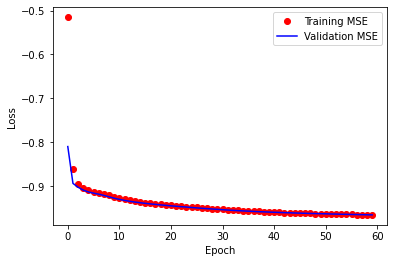

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training MSE',c='r')
plt.plot(epochs, val_loss, 'b', label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.savefig('Outputs/ae_training_hist.png')

We save our results.

In [ ]:
abstract_df = pd.read_csv('Outputs/abstract_df_clean_stopwords_lang_abstrlen.csv',index_col=0)
array_encoded_abstracts = encoder.predict(embedded_abstract)
encoded_abstracts = pd.concat((abstract_df[0:10000],pd.DataFrame(array_encoded_abstracts,index=abstract_df.index.values[0:10000])),axis=1)
encoded_abstracts.to_csv('Outputs/ae_encoded_abstract_df_64.csv')
encoded_abstracts.head()

,cord_uid,abstract,word_count,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
353391,sng9h1kq,challenging find genes stable transcripts refe...,128,-0.025721,0.517121,-0.479899,-0.605407,0.068654,0.673719,0.536603,...,0.080616,0.604826,-0.080643,-0.203930,-0.028942,-0.386709,0.642630,-0.059549,-0.432383,0.443774
48166,h9v5jqfc,etiology injury diverse multifactorial autopsy...,82,-0.016891,0.302273,-0.651515,-0.561381,0.010714,0.663162,0.557620,...,0.077701,0.211173,-0.224173,-0.292526,-0.205760,-0.668778,0.711367,-0.005670,-0.470185,0.133148
5918,k2crv9qb,angiotensin-converting enzyme ace considered p...,129,-0.000256,0.548198,-0.670758,-0.648719,0.019095,0.740356,0.519471,...,0.021436,0.833036,-0.425552,-0.284744,-0.222868,-0.831387,0.702441,-0.036318,-0.491804,0.417141
360052,ofutm6pc,efficacy povidone-iodine pvp-i products number...,85,-0.028173,0.192283,-0.459530,-0.671187,0.020363,0.756021,0.595849,...,0.025621,0.513213,-0.108698,-0.379482,-0.158120,-0.641619,0.671276,-0.024645,-0.444761,0.126058
77312,baog4f4h,retinoid acid receptor orphan receptor alpha r...,107,0.013979,0.720491,-0.608755,-0.521759,0.053027,0.670722,0.593300,...,0.059974,0.425503,-0.072745,-0.255448,-0.545533,-0.519312,0.719914,-0.052568,-0.517625,-0.135090
